## What to do
2. Proveďte explorativní analýzu zvolené datové sady. Pro každý následující bod implementujte odpovídající sekci ve zdrojovém kódu a zjištěné výsledky popište v dokumentaci:
    - **Pavel** prozkoumejte jednotlivé atributy datové sady, jejich typ a hodnoty, kterých nabývají (počet hodnot, nejčastější hodnoty, rozsah hodnot atd.)
    - **Pavel** prozkoumejte rozložení hodnot jednotlivých atributů pomocí vhodných grafů, zaměřte se i na to, jak hodnota jednoho či dvou atributů ovlivní rozložení hodnot jiného atributu. Do dokumentace vložte alespoň 5 různých grafů, zobrazujících zjištěná rozložení hodnot. Použijte různé typy grafů (např. bodový graf, histogram, krabicový nebo houslový graf, graf složený z více podgrafů apod.).
    - **Pavel** zjistěte, zda zvolená datová sada obsahuje nějaké odlehlé hodnoty.
    - proveďte podrobnou analýzu chybějící hodnot (celkový počet chybějících hodnot, počet objektů s více chybějícími hodnotami atd.).
    - proveďte korelační analýzu numerických atributů (k analýze využijte i grafy a korelační koeficienty).

In [527]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from os import getcwd
import seaborn as sns
from re import split

sns.set_theme()

### Global definition

In [528]:
data_dir = Path(getcwd()) / "data"

### Analysis of the dataset
- what is the shape of individual provided datasets
- what are the columns
- what are unique data types in the columns
- description of numerical and categorical columns

In [529]:
d1, d2, d3 = [pd.read_csv(f) for f in data_dir.iterdir() if f.suffix == ".csv"]

In [530]:
print(f"Shape: {d1.shape}")

Shape: (1253, 23)


In [531]:
d1.describe()

,Age,Yearly brutto salary (without bonus and stocks) in EUR,Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,"Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week"
count,1226.000000,1.253000e+03,8.850000e+02,373.000000
mean,32.509788,8.027904e+07,6.322459e+05,12.967828
std,5.663804,2.825061e+09,1.680508e+07,15.275174
min,20.000000,1.000100e+04,1.100000e+04,0.000000
25%,29.000000,5.880000e+04,5.500000e+04,0.000000
50%,32.000000,7.000000e+04,6.500000e+04,0.000000
75%,35.000000,8.000000e+04,7.500000e+04,30.000000
max,69.000000,1.000000e+11,5.000000e+08,40.000000


As we see from the description of the dataset, there might be some errors in the data frame that a are causing problems with deviation of the values, so we need to drop them.
Also some retyping of the data

In [532]:
d1.rename(columns={'Yearly brutto salary (without bonus and stocks) in EUR': 'yearly_brutto_salary',
                   'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country': 'yearly_brutto_salary_year_ago',
                   'Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week': 'shorten_week',
                   'Total years of experience': 'experience_year',
                   'Years of experience in Germany': 'experience_year_germany',
                   'Yearly bonus + stocks in EUR': 'yearly_bonus',
                   'Annual bonus+stocks one year ago. Only answer if staying in same country': 'yearly_bonus_year_ago',
                   'Number of vacation days': 'vacation_days',
                   'Have you lost your job due to the coronavirus outbreak?' : 'lost_job',
                   'Employment status': 'employment_status',
                   'Company size': 'company_size',
                   'Position': 'position',
                   'Your main technology / programming language': 'main_tech',
                   'Other technologies/programming languages you use often': 'other_tech',
                   'Seniority level': 'seniority_level',
                   'Company type': 'company_type',
                   'Main language at work': 'main_language',
                   'Сontract duration': 'contract_duration',
                   'City': 'city',
                   'Gender': 'gender',
                   'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR': 'additional_support',
                   'Age': 'age',
                   },
                   inplace=True)
d1 = d1[~d1.main_tech.isna()]

Analysis for missing/NaN values

In [533]:
print("Number of missing values in each column:")
print(d1.isna().sum())

Number of missing values in each column:
Timestamp                          0
age                               19
gender                             6
city                               0
position                           2
experience_year                    9
experience_year_germany           25
seniority_level                    5
main_tech                          0
other_tech                        87
yearly_brutto_salary               0
yearly_bonus                     358
yearly_brutto_salary_year_ago    317
yearly_bonus_year_ago            546
vacation_days                     48
employment_status                  8
contract_duration                 17
main_language                      8
company_size                      11
company_type                      16
lost_job                          11
shorten_week                     775
additional_support               698
dtype: int64


In [534]:
print(f'Number of rows with more than one NaN value: {d1[d1.isna().sum(axis=1) > 1].shape[0]}')
print(f'Maximum number of NaN values in on row: {d1.isna().sum(axis=1).max()}')

Number of rows with more than one NaN value: 830
Maximum number of NaN values in on row: 12


Remove rows where salary doesn't make sense

In [535]:
d1 = d1[(d1.yearly_brutto_salary < 8e5) & (d1.yearly_brutto_salary_year_ago < 8e5)]
print(f"Shape: {d1.shape}")

Shape: (807, 23)


Convert 'Total years of experience' column to numeric ignoring the errors

In [536]:
d1.experience_year = pd.to_numeric(np.char.replace(d1.experience_year.values.astype(str), ',', '.'), errors='coerce')

Transform 'Years of experience in Germany' column so there are correct data, change data type to numeric

In [537]:
d1.loc[np.isin(d1.experience_year_germany, ['3 (in Poland)', '4 (in Switzerland), 0 (in Germany)']), 'experience_year_germany'] = 0
d1.experience_year_germany = pd.to_numeric(d1.experience_year_germany, errors='coerce')

Correct 'Yearly bonus + stocks in EUR' column

In [538]:
d1.yearly_bonus = pd.to_numeric(d1.yearly_bonus, errors='coerce').fillna(0).astype(int)

Correct 'Annual bonus+stocks one year ago. Only answer if staying in same country' column

In [539]:
d1.yearly_bonus_year_ago = pd.to_numeric(d1.yearly_bonus_year_ago, errors='coerce').fillna(0).astype(int)

Correct 'Number of vacation days' column

In [540]:
max_vacation_days = pd.to_numeric(d1.vacation_days, errors='coerce').max()  # find max value from data that can be converted to numeric
d1.loc[d1.vacation_days.str.contains('unlimited|Unlimited') == True, 'vacation_days'] = max_vacation_days
d1.vacation_days = d1.vacation_days.str.extract('(\d+)', expand=False).fillna(0).astype(int)  # extract only digits from string

Correct 'Have you lost your job due to the coronavirus outbreak?' column

In [541]:
yes_no_map = {'Yes': True, 'No': False}
d1.lost_job = d1.lost_job.map(yes_no_map)
d1.lost_job.fillna(d1.lost_job.mode(), inplace=True)

Correct 'Employment status' column

Maybe we don't actually need column 'Employment status' because it is very unreliable and wouldn't give us any useful information

In [542]:
d1.employment_status.value_counts()

Full-time employee                                                     775
Self-employed (freelancer)                                              22
Part-time employee                                                       4
working student                                                          1
Intern                                                                   1
full-time, but 32 hours per week (it was my request, I'm a student)      1
Founder                                                                  1
Name: employment_status, dtype: int64

Correct 'Company size' column

In [543]:
d1 = d1[d1.company_size.notna()]
categories = ['up to 10', '11-50', '51-100', '101-1000', '1000+']
d1.company_size = pd.Categorical(d1.company_size, categories=categories, ordered=True)

Process technologies columns

In [544]:
d1.main_tech = d1.main_tech.str.replace('kubernetes', 'k8s', case=False)
d1.main_tech = d1.main_tech.str.replace(r'(javascript|javscript)', 'js', case=False)
d1.main_tech = d1.main_tech.str.replace('pythin', 'python', case=False)
d1.main_tech = d1.main_tech.str.replace('golang', 'go', case=False)
d1.main_tech = d1.main_tech.str.replace('c#', 'csharp', case=False)
d1.main_tech = d1.main_tech.str.replace(r'c\+\+', 'cpp', case=False)
d1.insert(1, "main_tech_list", d1.main_tech.str.lower().apply(lambda x: [i for i in split(r'\W+', x) if i])) 


/tmp/ipykernel_57299/4214351943.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  d1.main_tech = d1.main_tech.str.replace(r'(javascript|javscript)', 'js', case=False)
/tmp/ipykernel_57299/4214351943.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  d1.main_tech = d1.main_tech.str.replace(r'c\+\+', 'cpp', case=False)


Correct 'Seniority level' column: chose top 6 most frequent levels. We are taking Head == Principal

In [545]:
top_6 = d1.seniority_level.value_counts()[:6].index.tolist()
d1.loc[d1.seniority_level == 'Head', 'seniority_level'] = 'Principal' # merge Head and Principal
d1 = d1[np.isin(d1.seniority_level, top_6)]
level_categories = ['Junior', 'Middle', 'Senior', 'Lead', 'Principal']
d1.seniority_level = pd.Categorical(d1.seniority_level, categories=level_categories, ordered=True)

Change scale of some numeric attributes

In [546]:
d1.describe()

,age,experience_year,experience_year_germany,yearly_brutto_salary,yearly_bonus,yearly_brutto_salary_year_ago,yearly_bonus_year_ago,vacation_days,shorten_week
count,787.000000,794.000000,776.000000,796.000000,796.000000,796.000000,796.000000,796.000000,267.000000
mean,32.931385,9.207557,4.236985,72758.203518,14477.709799,66388.187186,14129.870603,27.574121,13.466292
std,5.478189,5.483040,3.588129,22509.863262,32380.873074,20897.394683,28665.279721,5.526907,15.648176
min,22.000000,0.000000,0.000000,14712.000000,0.000000,11000.000000,0.000000,0.000000,0.000000
25%,29.000000,5.000000,2.000000,60000.000000,0.000000,55000.000000,0.000000,27.000000,0.000000
50%,32.000000,8.000000,3.000000,70100.000000,1000.000000,65000.000000,0.000000,28.000000,0.000000
75%,36.000000,12.000000,5.000000,81000.000000,10000.000000,75000.000000,10000.000000,30.000000,30.000000
max,66.000000,40.000000,30.000000,250000.000000,450000.000000,230000.000000,300000.000000,60.000000,40.000000


In [547]:
d1.yearly_brutto_salary = d1.yearly_brutto_salary / 1e4
d1.yearly_brutto_salary_year_ago = d1.yearly_brutto_salary_year_ago / 1e4
d1.yearly_bonus = d1.yearly_bonus / 1e4
d1.yearly_bonus_year_ago = d1.yearly_bonus_year_ago / 1e4

In [548]:
d1.describe()

,age,experience_year,experience_year_germany,yearly_brutto_salary,yearly_bonus,yearly_brutto_salary_year_ago,yearly_bonus_year_ago,vacation_days,shorten_week
count,787.000000,794.000000,776.000000,796.000000,796.000000,796.000000,796.000000,796.000000,267.000000
mean,32.931385,9.207557,4.236985,7.275820,1.447771,6.638819,1.412987,27.574121,13.466292
std,5.478189,5.483040,3.588129,2.250986,3.238087,2.089739,2.866528,5.526907,15.648176
min,22.000000,0.000000,0.000000,1.471200,0.000000,1.100000,0.000000,0.000000,0.000000
25%,29.000000,5.000000,2.000000,6.000000,0.000000,5.500000,0.000000,27.000000,0.000000
50%,32.000000,8.000000,3.000000,7.010000,0.100000,6.500000,0.000000,28.000000,0.000000
75%,36.000000,12.000000,5.000000,8.100000,1.000000,7.500000,1.000000,30.000000,30.000000
max,66.000000,40.000000,30.000000,25.000000,45.000000,23.000000,30.000000,60.000000,40.000000


In [549]:
d1.describe(include=["object", 'category'])

,Timestamp,main_tech_list,gender,city,position,seniority_level,main_tech,other_tech,employment_status,contract_duration,main_language,company_size,company_type,lost_job,additional_support
count,796,796,791,796,794,796,796,751,794,792,795,796,793,791,324
unique,793,138,3,83,92,5,177,425,5,3,12,5,43,2,45
top,24/11/2020 14:07:23,[python],Male,Berlin,Software Engineer,Senior,Java,Javascript / Typescript,Full-time employee,Unlimited contract,English,1000+,Product,False,0
freq,2,154,678,443,280,381,141,26,769,759,645,303,513,756,122


### Graphical analysis of the dataset

(0.0, 40.0)

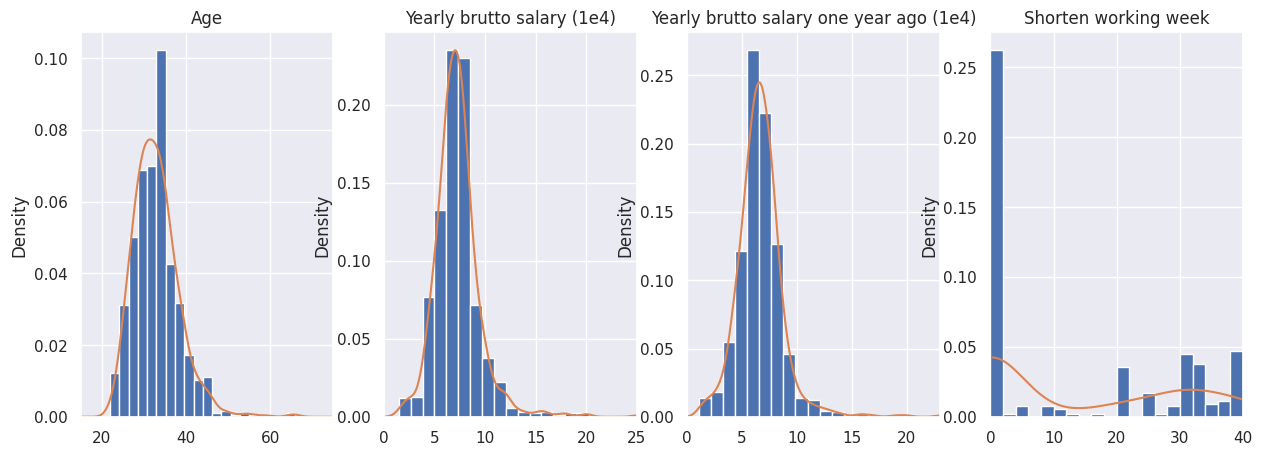

In [550]:
fix, ax = plt.subplots(1, 4, figsize=(15, 5))
# d1.hist(ax=ax)
ax[0].set_title("Age")
d1.age.hist(bins=20, density=True, ax=ax[0])
d1.age.plot(kind='kde', ax=ax[0])
ax[0].set_xlim(15, 75)

ax[1].set_title("Yearly brutto salary (1e4)")
d1.yearly_brutto_salary.hist(ax=ax[1], bins=20, density=True)
d1.yearly_brutto_salary.plot(kind='kde', ax=ax[1])
ax[1].set_xlim(0, d1.yearly_brutto_salary.max())

ax[2].set_title("Yearly brutto salary one year ago (1e4)")
d1.yearly_brutto_salary_year_ago.hist(ax=ax[2], bins=20, density=True)
d1.yearly_brutto_salary_year_ago.plot(kind='kde', ax=ax[2])
# ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[2].set_xlim(0, d1.yearly_brutto_salary_year_ago.max())

ax[3].set_title("Shorten working week")
d1.shorten_week.hist(ax=ax[3], bins=20, density=True)
d1.shorten_week.plot(kind='kde', ax=ax[3])
ax[3].set_xlim(0, d1.shorten_week.max())


(array([[ 14.,  29., 111., 266., 169.,  51.,  22.,   6.,   2.,   2.,   3.,
           2.,   0.,   0.,   1.],
        [  2.,  16.,  46.,  38.,   9.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.]]),
 array([ 1.4712    ,  3.03978667,  4.60837333,  6.17696   ,  7.74554667,
         9.31413333, 10.88272   , 12.45130667, 14.01989333, 15.58848   ,
        17.15706667, 18.72565333, 20.29424   , 21.86282667, 23.43141333,
        25.        ]),
 <a list of 2 BarContainer objects>)

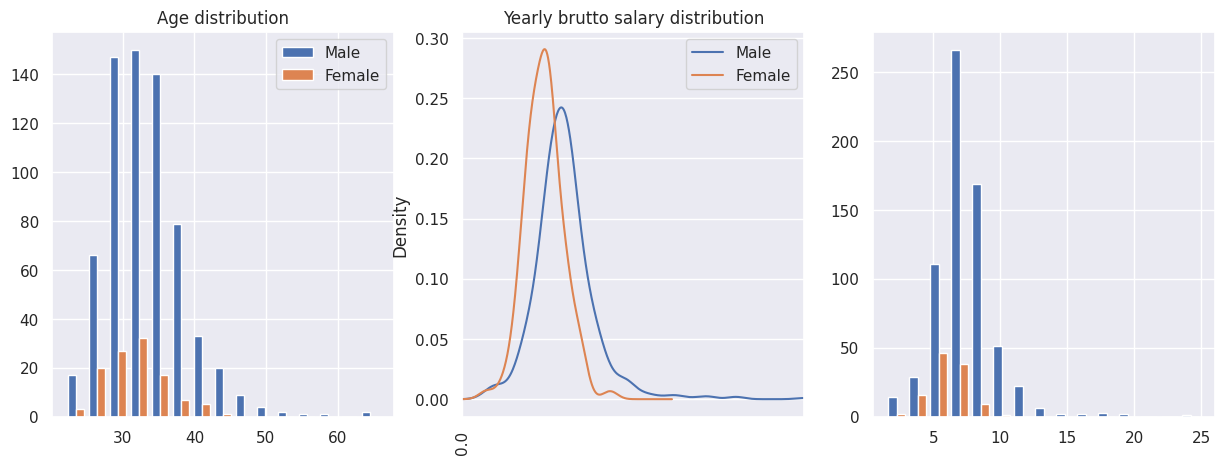

In [551]:
male = d1[d1.gender == "Male"]
female = d1[d1.gender == "Female"]
fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist([male.age, female.age], label=["Male", "Female"], bins=15)
ax1.legend()
ax1.set_title("Age distribution")

male.yearly_brutto_salary.plot(kind='kde', ax=ax2, label='Male')
female.yearly_brutto_salary.plot(kind='kde', ax=ax2, label='Female')
ax2.set_xlim(0, d1.yearly_brutto_salary.max())
ax2.set_xticks(np.arange(0, d1.yearly_brutto_salary.max(), 15000))
ax2.set_xticklabels(ax2.get_xticks(), rotation = 90)
ax2.legend()
ax2.set_title("Yearly brutto salary distribution")

ax3.hist([male.yearly_brutto_salary, female.yearly_brutto_salary], label=["Male", "Female"], bins=15)


Box plot of seniority level and salary

<AxesSubplot: xlabel='seniority_level', ylabel='yearly_brutto_salary'>

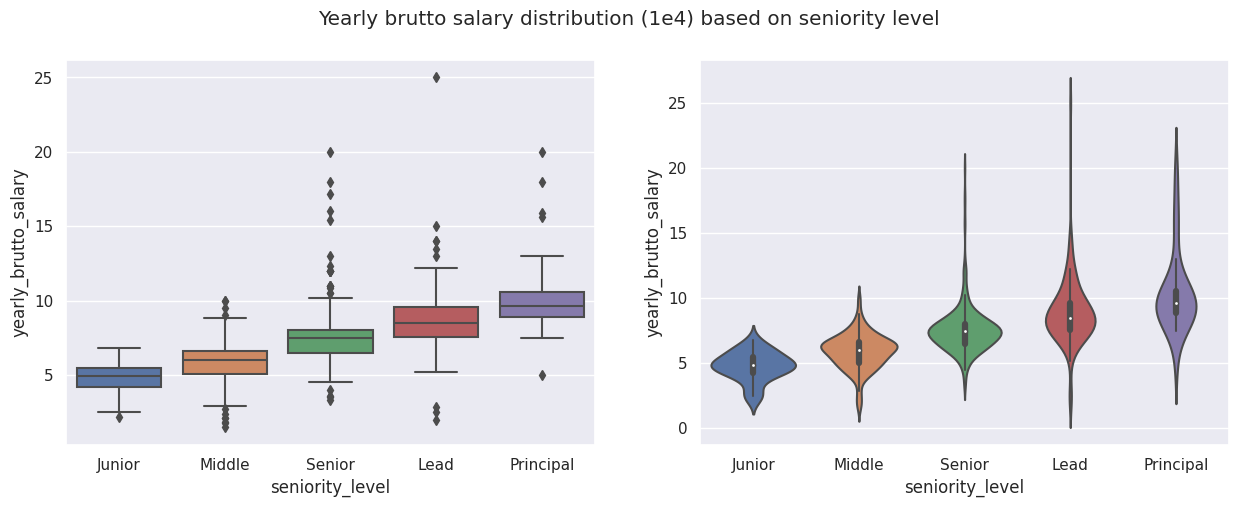

In [552]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Yearly brutto salary distribution (1e4) based on seniority level')
sns.boxplot(x='seniority_level', y='yearly_brutto_salary', data=d1, ax=ax1)
sns.violinplot(x='seniority_level', y='yearly_brutto_salary', data=d1, ax=ax2)


<AxesSubplot: xlabel='experience_year_germany', ylabel='yearly_brutto_salary'>

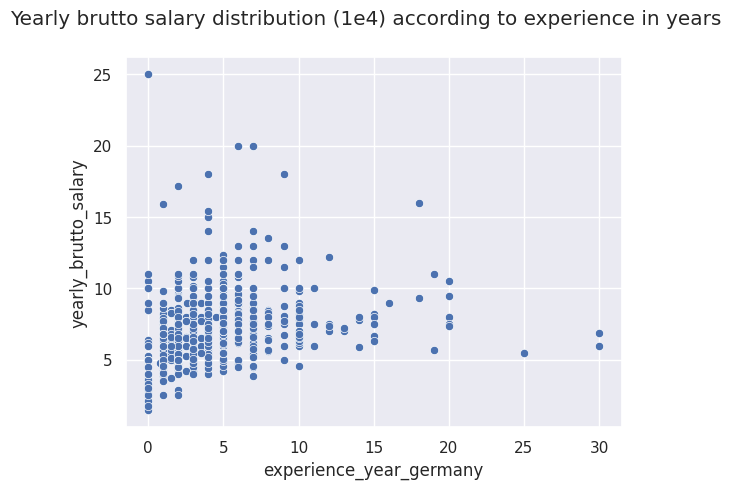

In [553]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Yearly brutto salary distribution (1e4) according to experience in years')
sns.scatterplot(y='yearly_brutto_salary', x='experience_year_germany', data=d1)

Analyses with technologies

<AxesSubplot: >

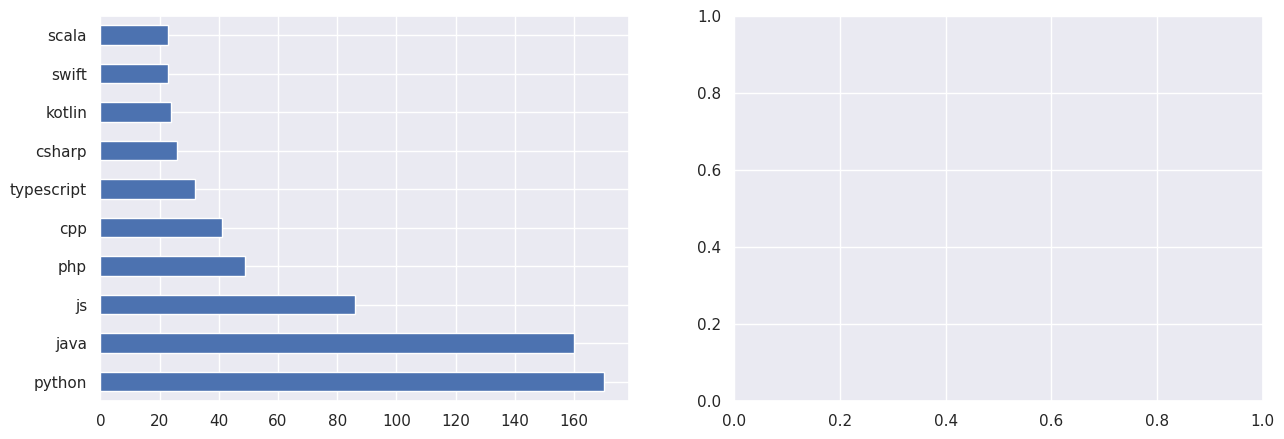

In [558]:
top_10 = d1.main_tech_list.explode().value_counts().head(10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
top_10.plot(kind='barh', ax=ax1)


## Correlation analysis

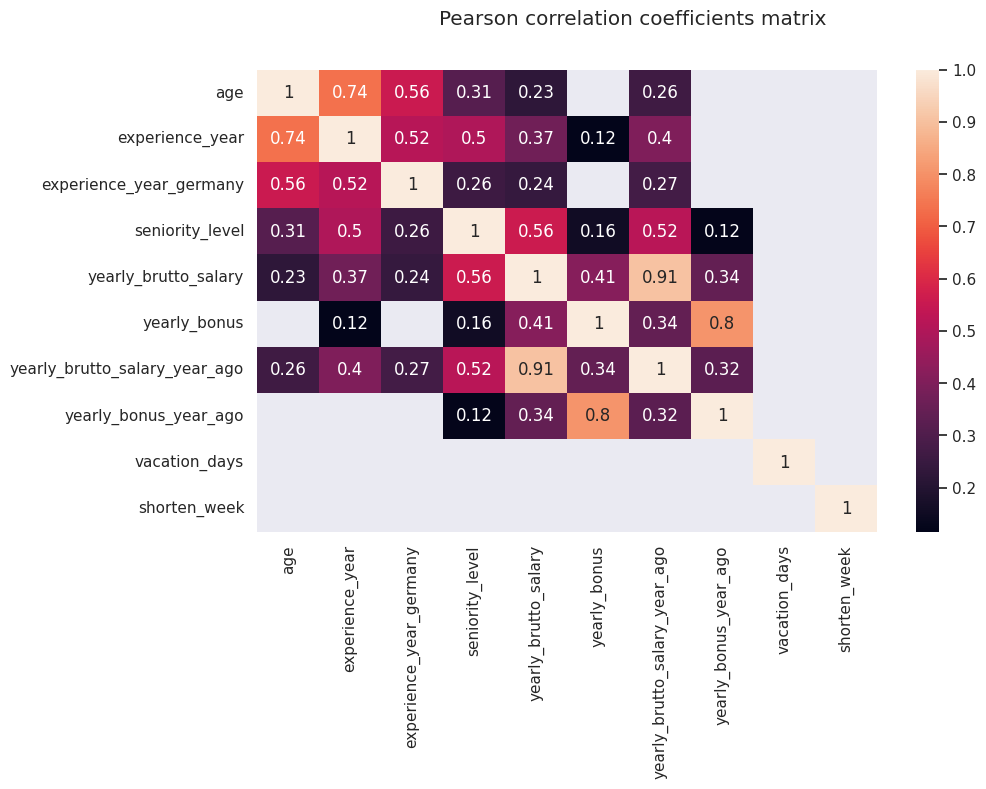

In [555]:
d1_copy = d1.copy()
d1_copy.seniority_level = d1_copy.seniority_level.cat.codes
correlations = d1_copy.corr(method='pearson', numeric_only=True)
correlations = correlations[(correlations < -0.1) | (correlations > 0.1)]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Pearson correlation coefficients matrix')
sns.heatmap(correlations, annot=True, ax=ax)
plt.show()

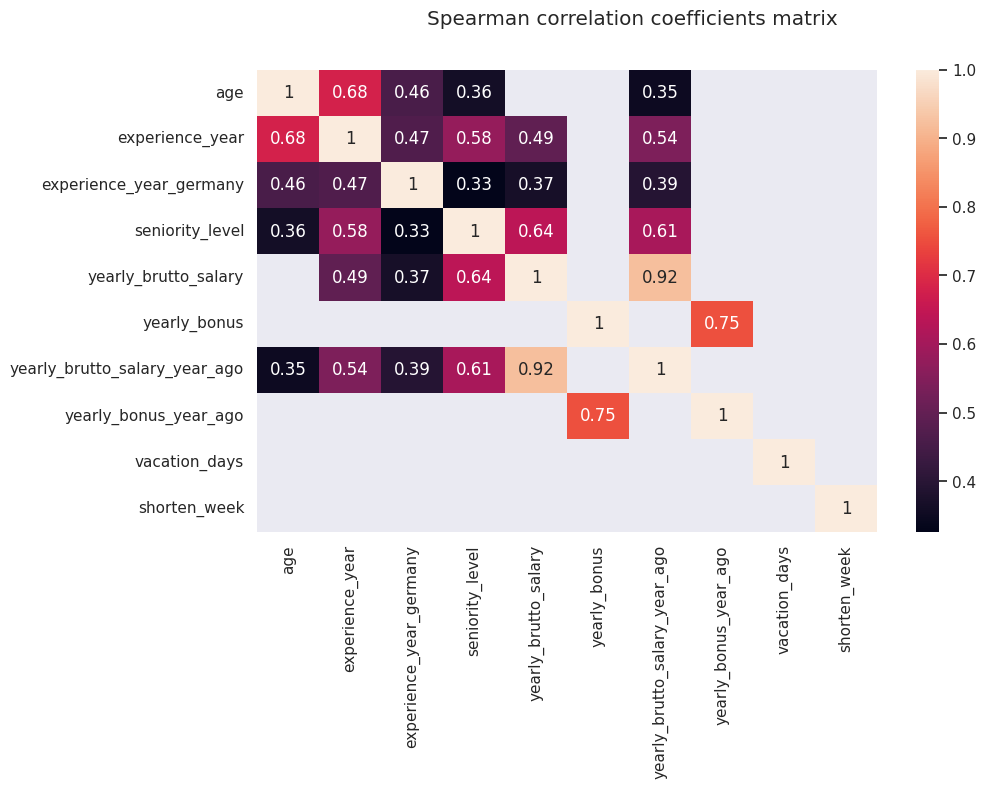

In [556]:
d1_copy = d1.copy()
d1_copy.seniority_level = d1_copy.seniority_level.cat.codes
correlations = d1_copy.corr(method='spearman', numeric_only=True)
correlations = correlations[(correlations < -0.1) | (correlations > 0.3)]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spearman correlation coefficients matrix')
sns.heatmap(correlations, annot=True, ax=ax)
plt.show()

### Data cleaning
#### Normalization to rang 0-1
`(v - min)/(max - min)`

In [557]:
d1.head()

,Timestamp,main_tech_list,age,gender,city,position,experience_year,experience_year_germany,seniority_level,main_tech,...,yearly_bonus_year_ago,vacation_days,employment_status,contract_duration,main_language,company_size,company_type,lost_job,shorten_week,additional_support
0,24/11/2020 11:14:15,[typescript],26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,TypeScript,...,1.0,30,Full-time employee,Unlimited contract,English,51-100,Product,False,NaN,NaN
1,24/11/2020 11:14:16,[ruby],26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,Ruby,...,0.5,28,Full-time employee,Unlimited contract,English,101-1000,Product,False,NaN,NaN
2,24/11/2020 11:14:21,"[js, typescript]",29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,js / Typescript,...,10.0,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,True,NaN,NaN
4,24/11/2020 11:15:46,"[csharp, net]",37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,csharp .NET,...,0.0,29,Full-time employee,Unlimited contract,English,101-1000,Product,False,NaN,NaN
5,24/11/2020 11:15:53,"[aws, gcp, python, k8s]",32.0,Male,Berlin,DevOps,5.0,1.0,Senior,"AWS, GCP, Python,K8s",...,0.5,30,Full-time employee,Unlimited contract,English,11-50,Startup,False,NaN,NaN
